# Assignment on clinical trial data

## About assignment: 

>Objective: Help people to discover relevant clinical trials suitable to their needs from a corpus of trials specific to the medical condition. Each clinical trial is defined by a set of inclusion and exclusion criteria specified in the text. Criteria can be demographic parameters like age, gender, location etc. and medical parameters like platelets count, sugar level etc. Visitors can search for trails by selecting medical condition,
specific demographic attributes and answering condition to specific questions that help to narrow down hundreds of trials to 10-15 trials. We need to identify set of questions(for each medical condition) that we can ask visitors 
and those should help to identify or filter relevant clinical trials.

## Question: How do we identify these questions that will help us to narrow down the clinical trials from 100 to 10-15?

--------------------------------------------------------------------------------------------------------------------
### Let's summarize the objective and Question
+ Questions need to be identified for each medical condition
+ For each medical condition several clinical trials are availabel
+ $\forall$ medical conditions, Each clinical trial = {demographic parameters, medical parameters}
+ For each medical condition, Finding questions => identifying important features/attributes that 'best separates' various clinical trials availabel. 

### Solution approach:
+ We should look for those trial atributes which have maximum discriminatory power in terms of separating clinical trials,  $X_i$'s
+ For example, features such as medical Conditions, Gender, Age, Phases reduces the search space ( $\Omega$) significantly. Also, we can use trial location (if given) to reduce $\Omega$
    * We can create a boolean-mask on whole dataframe and filer out the required data based on given input
+ We can monitor the matching trials after each given input, If at any of this matching stage the, $|\Omega| \leq 15$ we show the results.  
+ Otherwise, we need to further reduce $\Omega$,  we need to ask more specific questions based on trial parameters.
+ For this we can consider following,
#### Approach :

     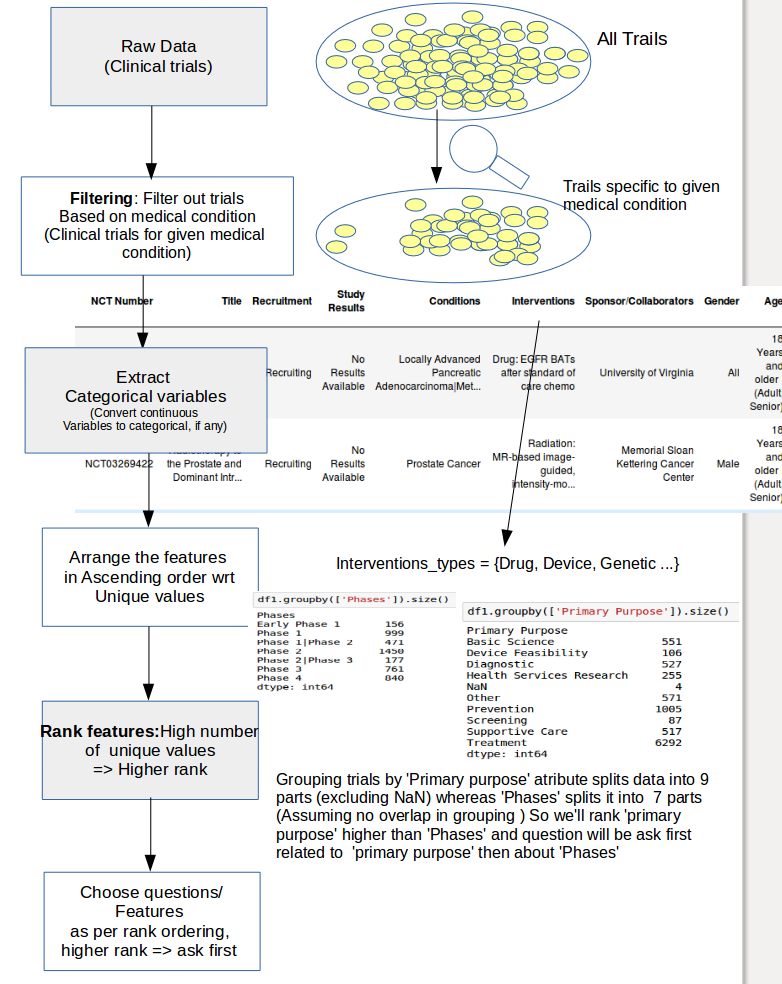

+ We can extract the information from strings of dataframe columns, by identifying patterns in string to get features (For example, We can extract unique types of Intervention methods)
+ We are looking for categorical variables which will partition the $\Omega$ into many subparts (see fig. for explanation)

Let's see How we can implement this approach in real world clinical trials data set


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from difflib import SequenceMatcher
from sklearn import metrics
import itertools
%matplotlib inline

#### Working with publically available dataset from https://ClinicalTrials.gov/ with All atributes and Recruiment= Recruiting

In [2]:
df = pd.read_csv('Clinical_trials.csv')  # Read CSV
print df.shape   # 10000 Clinical trails, with all 26 atributes
df.head()

(10000, 26)


,Rank,NCT Number,Title,Recruitment,Study Results,Conditions,Interventions,Sponsor/Collaborators,Gender,Age,...,First Received,Start Date,Completion Date,Last Updated,Last Verified,Results First Received,Acronym,Primary Completion Date,Outcome Measures,URL
0,1,NCT03269526,"BATs Treatment for Pancreatic Cancer, Phase Ib/II",Recruiting,No Results Available,Locally Advanced Pancreatic Adenocarcinoma|Met...,Drug: EGFR BATs after standard of care chemo,University of Virginia,All,"18 Years and older (Adult, Senior)",...,"August 11, 2017","July 28, 2017","June 1, 2022","August 30, 2017",August 2017,No Study Results Posted,null,"June 1, 2020",Incidence of adverse events|Overall survival|C...,https://ClinicalTrials.gov/show/NCT03269526
1,2,NCT03269422,Radiotherapy to the Prostate and Dominant Intr...,Recruiting,No Results Available,Prostate Cancer,"Radiation: MR-based image-guided, intensity-mo...",Memorial Sloan Kettering Cancer Center,Male,"18 Years and older (Adult, Senior)",...,"August 29, 2017","August 28, 2017","August 28, 2019","August 30, 2017",August 2017,No Study Results Posted,null,"August 28, 2019",Treatment related toxicity of ultra-hypofracti...,https://ClinicalTrials.gov/show/NCT03269422
2,3,NCT03269344,Gabapentin for the Reduction of Radiation Ther...,Recruiting,No Results Available,Oropharynx Cancer,Drug: Gabapentin|Drug: Placebo Oral Capsule,Henry Ford Health System,All,"18 Years and older (Adult, Senior)",...,"June 5, 2017","June 5, 2017",March 2019,"August 30, 2017",August 2017,No Study Results Posted,null,January 2019,Change in quality of life from mucositis measu...,https://ClinicalTrials.gov/show/NCT03269344
3,4,NCT03269279,Mifepristone and Misoprostol for 2nd Trimester...,Recruiting,No Results Available,"Medical; Abortion, Fetus",Drug: Mifepristone|Drug: Misoprostol,Gynuity Health Projects,Female,"Child, Adult, Senior",...,"July 14, 2017","May 20, 2017","May 19, 2018","August 30, 2017",August 2017,No Study Results Posted,null,"May 19, 2018",Rate of successful abortion,https://ClinicalTrials.gov/show/NCT03269279
4,5,NCT03269227,Accelerated Hypofractionated Radiotherapy in t...,Recruiting,No Results Available,Malignant Pleural Mesothelioma,Radiation: Accelerated hypofractionation with ...,Istituto Scientifico Romagnolo per lo Studio e...,All,"18 Years to 85 Years (Adult, Senior)",...,"August 16, 2017",August 2017,July 2020,"August 29, 2017",August 2017,No Study Results Posted,MesoRT,July 2020,assessment of acute and late toxicity|Overall ...,https://ClinicalTrials.gov/show/NCT03269227


In [3]:
df.keys()  # Attributes list

Index([u'Rank', u'NCT Number', u'Title', u'Recruitment', u'Study Results',
       u'Conditions', u'Interventions', u'Sponsor/Collaborators', u'Gender',
       u'Age', u'Phases', u'Enrollment', u'Funded Bys', u'Study Types',
       u'Study Designs', u'Other IDs', u'First Received', u'Start Date',
       u'Completion Date', u'Last Updated', u'Last Verified',
       u'Results First Received', u'Acronym', u'Primary Completion Date',
       u'Outcome Measures', u'URL'],
      dtype='object')

#### Basic Exploration

In [4]:
print len(df['NCT Number'].unique()) # All trials are different, Trails are linked to title uniquely.   

10000


In [5]:
set(df['Recruitment'].values ) # Same value in all rows

{'Recruiting'}

In [6]:
set(df['Study Results'].values) # Same value in all rows

{'No Results Available'}

---
Gives current enrollment ($E$) in each trail, We can turn this into a categorical variable with categories small_scale ($E\leq 100$), medium_scale ( $ 100 < E \leq 1000$), large_scale ($E > 1000$),   

(array([ 1862.,   785.,   492.]),
 array([100, 200, 300, 400]),
 <a list of 3 Patch objects>)

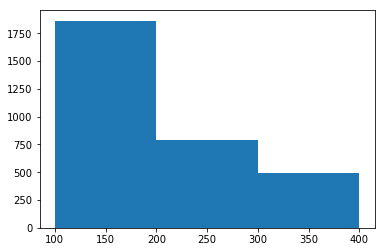

In [7]:
# See distribution of number of enrollments to decide scale thresholds
#plt.ylim(0, 20)
plt.hist(sorted(df[df['Enrollment'].values != 'null'].Enrollment.values.astype(int))[::-1], bins=[100*i for i in range(1,5)])
#pd.cut(df['Enrollment'].values.astype(int), range(1,2000, 1000) , right=False)


In [8]:
len(df['Conditions'].unique()) # Some clinical trials are for same/similar medical condition, Let's group data by medical conditions

6618

In [9]:
#Grouping is done based on string matching, so we see ADHD, ADHD|Insomnia, ADHD|Lifestyle-Related Condition|Food Habits  etc.
#As different medical conditions, we would like to have these clubed together
df.groupby('Conditions').size()  

Conditions
3 or More Chronic Conditions for 6 Months or Longer|5 or More Regular Drugs                                                                                                                                                                                                                                                                                                           2
A Patient Discharged From an Acute-care Hospital Who Had an Acute Illness                                                                                                                                                                                                                                                                                                             1
ACL Injury|ACL - Anterior Cruciate Ligament Rupture|ACL Sprain|ACL Tear                                                                                                                                                                      

In [10]:
set(df['Funded Bys'].values) # Trials are funded by one or group of institutions

{'Industry',
 'Industry|NIH',
 'Industry|NIH|Other',
 'Industry|Other',
 'Industry|Other|NIH',
 'Industry|Other|U.S. Fed',
 'Industry|U.S. Fed',
 'Industry|U.S. Fed|Other',
 'NIH',
 'NIH|Industry|Other',
 'NIH|Other|Industry',
 'Other',
 'Other|Industry',
 'Other|Industry|NIH',
 'Other|Industry|U.S. Fed',
 'Other|NIH',
 'Other|NIH|Industry',
 'Other|NIH|U.S. Fed',
 'Other|NIH|U.S. Fed|Industry',
 'Other|U.S. Fed',
 'Other|U.S. Fed|Industry',
 'Other|U.S. Fed|NIH',
 'U.S. Fed',
 'U.S. Fed|Industry',
 'U.S. Fed|Other',
 'U.S. Fed|Other|Industry'}

In [11]:
set(df['Study Types'].values)     # Downloaded only 'Interventional'

{'Interventional'}

In [12]:
set(df['Other IDs'].values)

{nan,
 'N-20160071',
 '1715-133-856',
 '15010MUHC',
 'H1704-083-846',
 '201705166',
 'ENMSET',
 '1400-0001|2016-003224-24',
 'IRB00007128',
 '1014802-204|2015-004796-68',
 'MCC-15-11083|NCI-2016-01980|P30CA016059',
 'M16-17-027',
 'EPOC1504',
 'AAAR4283',
 '1501015803',
 '19399',
 'VICC THO 1684|NCI-2016-01532',
 'Poetry-1',
 '19713',
 'RGV-GARM3',
 'CHS01N-1892',
 'PHD/0194/2557',
 'CO-338-045|2015-004394-32',
 'CR108261|2016-003328-22|56022473MDS2002',
 '4R15/032|PI15/00114|SLT002/16/00112',
 'CAIN457AUS05T',
 '71542613',
 '2017/05/1',
 '16-1341',
 'Gamma-GBM',
 '16-211-3',
 'ACP-103-035|2016-003435-38',
 'STU00203761',
 'KYZ2016-006',
 'GCT1021-01',
 'FloridaIU',
 'QPR-17-03',
 '1609018390',
 'ENF_APO_2017',
 '2016P000268',
 'STH19471',
 'GCO 15-0980',
 'D24-DIPG',
 'MDV3800-01|C3441001|2016-002536-33',
 '20160711',
 'STH19479',
 '9702 Breast PET Feasibility|16/LO/0507',
 'FW2016-F09',
 '131115',
 'VENS',
 'TTYMG1403',
 'H16-02273',
 'OSR - Prot. SMARTAPP',
 '2000020343',
 'CIP-1010

In [13]:
set(df['First Received'].values)

{'April 1, 2016',
 'April 1, 2017',
 'April 10, 2017',
 'April 11, 2015',
 'April 11, 2017',
 'April 12, 2016',
 'April 12, 2017',
 'April 13, 2016',
 'April 13, 2017',
 'April 14, 2016',
 'April 14, 2017',
 'April 15, 2016',
 'April 15, 2017',
 'April 16, 2015',
 'April 16, 2017',
 'April 17, 2017',
 'April 18, 2016',
 'April 18, 2017',
 'April 19, 2016',
 'April 19, 2017',
 'April 2, 2017',
 'April 20, 2016',
 'April 20, 2017',
 'April 21, 2016',
 'April 21, 2017',
 'April 22, 2017',
 'April 23, 2014',
 'April 23, 2017',
 'April 24, 2016',
 'April 24, 2017',
 'April 25, 2016',
 'April 25, 2017',
 'April 26, 2016',
 'April 26, 2017',
 'April 27, 2016',
 'April 27, 2017',
 'April 28, 2016',
 'April 28, 2017',
 'April 29, 2016',
 'April 29, 2017',
 'April 3, 2017',
 'April 30, 2017',
 'April 4, 2017',
 'April 5, 2017',
 'April 6, 2016',
 'April 6, 2017',
 'April 7, 2016',
 'April 7, 2017',
 'April 8, 2016',
 'April 8, 2017',
 'April 9, 2017',
 'August 1, 2016',
 'August 1, 2017',
 'Augu

In [14]:
set(df['Start Date'].values)

{'April 1, 2011',
 'April 1, 2014',
 'April 1, 2015',
 'April 1, 2016',
 'April 1, 2017',
 'April 10, 2015',
 'April 10, 2017',
 'April 11, 2016',
 'April 11, 2017',
 'April 12, 2016',
 'April 12, 2017',
 'April 13, 2016',
 'April 13, 2017',
 'April 14, 2017',
 'April 15, 2016',
 'April 15, 2017',
 'April 16, 2013',
 'April 16, 2015',
 'April 16, 2017',
 'April 17, 2017',
 'April 18, 2016',
 'April 18, 2017',
 'April 19, 2017',
 'April 2, 2017',
 'April 20, 2016',
 'April 20, 2017',
 'April 2010',
 'April 2013',
 'April 2014',
 'April 2015',
 'April 2016',
 'April 2017',
 'April 21, 2016',
 'April 21, 2017',
 'April 22, 2016',
 'April 22, 2017',
 'April 23, 2016',
 'April 23, 2017',
 'April 24, 2015',
 'April 24, 2017',
 'April 25, 2017',
 'April 26, 2017',
 'April 27, 2017',
 'April 28, 2016',
 'April 28, 2017',
 'April 29, 2017',
 'April 3, 2007',
 'April 3, 2017',
 'April 30, 2015',
 'April 30, 2017',
 'April 4, 2017',
 'April 5, 2016',
 'April 5, 2017',
 'April 6, 2015',
 'April 6,

In [15]:
set(df['Sponsor/Collaborators'].values)

{'Jinan Military General Hospital',
 'Cancer Institute and Hospital, Chinese Academy of Medical Sciences|Sun Yat-sen University|Fudan University|Chinese PLA General Hospital|Beijing Chest Hospital',
 'Institute of Tropical Medicine, Belgium|Ecole Nationale de Sant\xc3\xa9 Publique, Rabat, Morocco',
 'Hospital of Prato',
 'Actelion',
 'Kaohsiung Veterans General Hospital.|Kaohsiung Medical University Chung-Ho Memorial Hospital',
 'Zai Lab Pty. Ltd.',
 'Elisabeth-TweeSteden Ziekenhuis|University of Tilburg|ZonMw: The Netherlands Organisation for Health Research and Development',
 'Uppsala University|Fundation of Ester \xc3\x85sberg Lindbergs memmories, Falun; Sweden|Center for clnical research Dalarna, Sweden',
 'Levanger Hospital|Norwegian University of Science and Technology|St. Olavs Hospital',
 'BioClin Therapeutics, Inc.',
 "St George's, University of London",
 'Federal University of Health Science of Porto Alegre',
 'Cambridge Cardiac Care Centre',
 'Linkoeping University',
 'Shand

---
We can similarly get the idea of what values are contained in various atributes. 
For further analysis to find out questions to reduce serach space we can ignore some of the attributes, since many of them have either single value or intutively not relevant to assignment problem. For example. it is not obvious that people will know Acronym, URL or Title of trial. We want to look for those attributes which are relevant to patient and for these attributes patient knows the values.  

In [16]:
# Creating a Copy of original dataframe, so that any changes hereafter wont affect original df
df1 = df.copy()
df1.shape

(10000, 26)

In [17]:
to_drop = ['Rank','Title', 'Recruitment', 'Study Results', 'Funded Bys', 'Study Types',
       'Other IDs', 'First Received', 'Start Date', 'Sponsor/Collaborators',
       'Last Updated', 'Last Verified',
       'Results First Received', 'Acronym', 'Primary Completion Date',
       'Outcome Measures', 'URL']
df1.drop(to_drop, axis=1, inplace=True)

In [18]:
print df1.shape
df1.head()

(10000, 9)


,NCT Number,Conditions,Interventions,Gender,Age,Phases,Enrollment,Study Designs,Completion Date
0,NCT03269526,Locally Advanced Pancreatic Adenocarcinoma|Met...,Drug: EGFR BATs after standard of care chemo,All,"18 Years and older (Adult, Senior)",Phase 1|Phase 2,22,Intervention Model: Single Group Assignment|Ma...,"June 1, 2022"
1,NCT03269422,Prostate Cancer,"Radiation: MR-based image-guided, intensity-mo...",Male,"18 Years and older (Adult, Senior)",Phase 1,30,Intervention Model: Single Group Assignment|Ma...,"August 28, 2019"
2,NCT03269344,Oropharynx Cancer,Drug: Gabapentin|Drug: Placebo Oral Capsule,All,"18 Years and older (Adult, Senior)",Phase 3,60,Allocation: Randomized|Intervention Model: Par...,March 2019
3,NCT03269279,"Medical; Abortion, Fetus",Drug: Mifepristone|Drug: Misoprostol,Female,"Child, Adult, Senior",Phase 3,100,Intervention Model: Single Group Assignment|Ma...,"May 19, 2018"
4,NCT03269227,Malignant Pleural Mesothelioma,Radiation: Accelerated hypofractionation with ...,All,"18 Years to 85 Years (Adult, Senior)",NaN,30,Intervention Model: Single Group Assignment|Ma...,July 2020


In [19]:
gender_grouped = df1.groupby(['Gender']) # Number of Gender specific trials
gender_grouped.describe()

Age                                                     \
       count unique                                   top  freq   
Gender                                                            
All     8494    797  18 Years and older   (Adult, Senior)  2892   
Female  1023    203  18 Years and older   (Adult, Senior)   281   
Male     483    122  18 Years and older   (Adult, Senior)   124   

       Completion Date                            Conditions         ...   \
                 count unique            top freq      count unique  ...    
Gender                                                               ...    
All               8494   1102  December 2017  392       8494   5693  ...    
Female            1023    305  December 2017   62       1023    756  ...    
Male               483    231  December 2017   28        483    327  ...    

         NCT Number      Phases                       Study Designs         \
                top freq  count unique      top  freq         count unique   
Gender                                                                       
All     NCT03179995    1   4133      7  Phase 2  1258          8491    444   
Female  NCT03015129    1    448      7  Phase 2   125          1022    152   
Male    NCT02940080    1    273      7  Phase 1   114           483    132   

                                                                 
                                                      top  freq  
Gender                                                           
All     Intervention Model: Single Group Assignment|Ma...  1498  
Female  Allocation: Randomized|Intervention Model: Par...   153  
Male    Intervention Model: Single Group Assignment|Ma...    86  

[3 rows x 32 columns]

Mine some features from Interventions attribute

In [20]:
def h1(x):
    '''
    Helper function to mine Intervention types broadly 
    '''
    T = []
    #print x
    fl = 1
    try :
        x = '|' + x
    except TypeError:
        T.append('nan')
        fl = 0
    while fl and len(x) >0 :
        try :
            id1 = x.index('|')
            id2 = x.index(':')
        except ValueError:
            break
        if not x[id1+1:id2] in T:
            to_append = x[id1+1:id2]
            to_append = to_append.replace(' ','_')
            T.append(to_append)
        x = x[id2+2:] 
    return ' '.join(T)
    #return T

df1['Intervention_types'] = df1['Interventions'].apply(lambda x: h1(x) )


In [21]:
# Get list of unique Intervention types
type_interven = []
idx = 0
for tag_str in df1.Intervention_types.values:
    types = tag_str.split(' ')
    for t in types:
        if t not in type_interven:
            if not t=='':
                #print idx            
                type_interven.append(t)
    idx += 1
print type_interven

['Drug', 'Radiation', 'Dietary_Supplement', 'Diagnostic_Test', 'Device', 'Other', 'Behavioral', 'Biological', 'Procedure', 'Combination_Product', 'Genetic']


In [22]:
# Add onehot features for Intervention_type
for t in type_interven:
    df1[t] = df1['Intervention_types'].apply(lambda x: 1 if t in x.split(' ') else 0)
df1.iloc[0]

NCT Number                                                   NCT03269526
Conditions             Locally Advanced Pancreatic Adenocarcinoma|Met...
Interventions               Drug: EGFR BATs after standard of care chemo
Gender                                                               All
Age                                 18 Years and older   (Adult, Senior)
Phases                                                   Phase 1|Phase 2
Enrollment                                                            22
Study Designs          Intervention Model: Single Group Assignment|Ma...
Completion Date                                             June 1, 2022
Intervention_types                                                  Drug
Drug                                                                   1
Radiation                                                              0
Dietary_Supplement                                                     0
Diagnostic_Test                                    

---
Know what Study Designs types are, the subtypes are categorical in this case

In [23]:
# Study designs types, ['Intervention_Model', 'Masking', 'Primary_Purpose', 'Allocation', 'nan']
df1['S_types'] = df1['Study Designs'].apply(lambda x: h1(x) )

In [24]:
# Get list of unique Study design types
# For some trials no Study design type (nan) is indicated
type_study = []
idx = 0
for tag_str in df1.S_types.values:
    types = tag_str.split(' ')
    for t in types:
        if t not in type_study:
            if not t=='':
                #print idx            
                type_study.append(t)
    idx += 1
print type_study

['Intervention_Model', 'Masking', 'Primary_Purpose', 'Allocation', 'nan']


In [25]:
def h2(x):
    '''
    Helper function to mine a dict {Study_Design_types : Subtype } 
    '''
    T = {}
    #print x
    fl = 1
    
    try :
        x = x.split('|')
        for ele in x:
            ele = ele.split(': ')
            T[ele[0]] = ele[1]
    except (AttributeError,TypeError):
        pass
    return T

df1['S_type3'] = df1['Study Designs'].apply(lambda x: h2(x) );

In [26]:
# Creating Dataframe listing study design sub_types 
SD_subtype = pd.DataFrame.from_dict({}, orient='index')
for i in range(len(df1)):
    s = df1.iloc[i]['S_type3']
    if s != {}:
        D = pd.DataFrame.from_dict(s, orient='index').T
    else:
        D = {'Intervention Model': 'NaN', 'Masking':'NaN', 'Primary Purpose':'NaN', 'Allocation': 'NaN'}
        D = pd.DataFrame.from_dict(D,orient='index').T
    SD_subtype = pd.concat([SD_subtype, D], ignore_index=True)
SD_subtype.size


40000

In [27]:
# Appending into original dataframe
#pd.merge(SD_subtype, df1, on=['Intervention Model', 'Masking', 'Primary Purpose', 'Allocation'])
df1 = pd.concat([df1, SD_subtype], axis=1)

In [28]:
df1 = df1.drop(['S_types', 'S_type3'], axis=1)
df1.head()

,NCT Number,Conditions,Interventions,Gender,Age,Phases,Enrollment,Study Designs,Completion Date,Intervention_types,...,Other,Behavioral,Biological,Procedure,Combination_Product,Genetic,Allocation,Intervention Model,Masking,Primary Purpose
0,NCT03269526,Locally Advanced Pancreatic Adenocarcinoma|Met...,Drug: EGFR BATs after standard of care chemo,All,"18 Years and older (Adult, Senior)",Phase 1|Phase 2,22,Intervention Model: Single Group Assignment|Ma...,"June 1, 2022",Drug,...,0,0,0,0,0,0,NaN,Single Group Assignment,None (Open Label),Treatment
1,NCT03269422,Prostate Cancer,"Radiation: MR-based image-guided, intensity-mo...",Male,"18 Years and older (Adult, Senior)",Phase 1,30,Intervention Model: Single Group Assignment|Ma...,"August 28, 2019",Radiation,...,0,0,0,0,0,0,NaN,Single Group Assignment,None (Open Label),Treatment
2,NCT03269344,Oropharynx Cancer,Drug: Gabapentin|Drug: Placebo Oral Capsule,All,"18 Years and older (Adult, Senior)",Phase 3,60,Allocation: Randomized|Intervention Model: Par...,March 2019,Drug,...,0,0,0,0,0,0,Randomized,Parallel Assignment,"Quadruple (Participant, Care Provider, Investi...",Supportive Care
3,NCT03269279,"Medical; Abortion, Fetus",Drug: Mifepristone|Drug: Misoprostol,Female,"Child, Adult, Senior",Phase 3,100,Intervention Model: Single Group Assignment|Ma...,"May 19, 2018",Drug,...,0,0,0,0,0,0,NaN,Single Group Assignment,None (Open Label),Treatment
4,NCT03269227,Malignant Pleural Mesothelioma,Radiation: Accelerated hypofractionation with ...,All,"18 Years to 85 Years (Adult, Senior)",NaN,30,Intervention Model: Single Group Assignment|Ma...,July 2020,Radiation,...,0,0,0,0,0,0,NaN,Single Group Assignment,None (Open Label),Treatment


In [29]:
df1.groupby('Intervention Model').size()

Intervention Model
Crossover Assignment        677
Factorial Assignment        139
NaN                           4
Parallel Assignment        6125
Sequential Assignment       207
Single Group Assignment    2840
dtype: int64

In [30]:
df1.groupby('Masking').size()

Masking
Double                                                                        5
Double (Care Provider, Investigator)                                         15
Double (Care Provider, Outcomes Assessor)                                    24
Double (Investigator, Outcomes Assessor)                                    148
Double (Participant, Care Provider)                                          87
Double (Participant, Investigator)                                          609
Double (Participant, Outcomes Assessor)                                     298
NaN                                                                           4
None (Open Label)                                                          5741
Quadruple (Participant, Care Provider, Investigator, Outcomes Assessor)     924
Single                                                                        2
Single (Care Provider)                                                       37
Single (Investigator)           

In [31]:
df1.groupby(['Primary Purpose']).size()

Primary Purpose
Basic Science                551
Device Feasibility           106
Diagnostic                   527
Health Services Research     255
NaN                            4
Other                        571
Prevention                  1005
Screening                     87
Supportive Care              517
Treatment                   6292
dtype: int64

In [32]:
df1.groupby(['Allocation']).size()

Allocation
NaN                  4
Non-Randomized     976
Randomized        6339
dtype: int64

In [33]:
def similar(a,b):
    ''' Returns a score based on matching strings'''
    return SequenceMatcher(None, a, b).ratio()



In [34]:
medical_cond = 'cancer'
# Searching for a given medical condition
LowerCase_df1 = df1.apply(lambda x: x.astype(str).str.lower())
df1[LowerCase_df1['Conditions'].str.contains(medical_cond) ==True]


,NCT Number,Conditions,Interventions,Gender,Age,Phases,Enrollment,Study Designs,Completion Date,Intervention_types,...,Other,Behavioral,Biological,Procedure,Combination_Product,Genetic,Allocation,Intervention Model,Masking,Primary Purpose
1,NCT03269422,Prostate Cancer,"Radiation: MR-based image-guided, intensity-mo...",Male,"18 Years and older (Adult, Senior)",Phase 1,30,Intervention Model: Single Group Assignment|Ma...,"August 28, 2019",Radiation,...,0,0,0,0,0,0,NaN,Single Group Assignment,None (Open Label),Treatment
2,NCT03269344,Oropharynx Cancer,Drug: Gabapentin|Drug: Placebo Oral Capsule,All,"18 Years and older (Adult, Senior)",Phase 3,60,Allocation: Randomized|Intervention Model: Par...,March 2019,Drug,...,0,0,0,0,0,0,Randomized,Parallel Assignment,"Quadruple (Participant, Care Provider, Investi...",Supportive Care
5,NCT03268993,Head and Neck Cancer|Head and Neck Squamous Ce...,Dietary Supplement: Avmacol,All,"18 Years and older (Adult, Senior)",NaN,36,Intervention Model: Single Group Assignment|Ma...,June 2020,Dietary_Supplement,...,0,0,0,0,0,0,NaN,Single Group Assignment,None (Open Label),Basic Science
10,NCT03268785,Thyroid Cancer|Parathyroid; Absent|Hypocalcemi...,Diagnostic Test: Intraoperative identification...,All,18 Years to 60 Years (Adult),NaN,200,Allocation: Non-Randomized|Intervention Model:...,"August 1, 2020",Diagnostic_Test,...,0,0,0,0,0,0,Non-Randomized,Sequential Assignment,None (Open Label),Diagnostic
21,NCT03268382,High-grade Serous Ovarian Cancer,Drug: APR-246|Drug: Pegylated Liposomal Doxoru...,Female,"18 Years and older (Adult, Senior)",Phase 2,25,Intervention Model: Single Group Assignment|Ma...,November 2018,Drug,...,0,0,0,0,0,0,NaN,Single Group Assignment,None (Open Label),Treatment
30,NCT03267914,Dental Caries|Oral Cavity Cancer|Oral Complica...,Other: Tray|Other: Brush,All,"18 Years to 100 Years (Adult, Senior)",NaN,45,Allocation: Randomized|Intervention Model: Par...,"May 31, 2019",Other,...,1,0,0,0,0,0,Randomized,Parallel Assignment,None (Open Label),Prevention
45,NCT03267173,Pancreatic Cancer|CAR,Drug: Chimeric antigen receptor T cell,Male,18 Years to 65 Years (Adult),Early Phase 1,10,Intervention Model: Single Group Assignment|Ma...,June 2019,Drug,...,0,0,0,0,0,0,NaN,Single Group Assignment,None (Open Label),Treatment
81,NCT03264807,Gastric Cancer,Procedure: D2 lymphadenectomy|Procedure: D2 an...,All,"19 Years and older (Adult, Senior)",Phase 3,518,Allocation: Randomized|Intervention Model: Par...,"December 31, 2021",Procedure,...,0,0,0,1,0,0,Randomized,Parallel Assignment,None (Open Label),Treatment
110,NCT03263520,Cachexia; Cancer,Drug: Nandrolone Decanoate|Drug: Dexamethasone,All,"18 Years and older (Adult, Senior)",NaN,60,Allocation: Randomized|Intervention Model: Par...,"October 31, 2017",Drug,...,0,0,0,0,0,0,Randomized,Parallel Assignment,"Double (Investigator, Outcomes Assessor)",Supportive Care
112,NCT03263429,Colorectal Cancer|Metastatic Colorectal Cancer...,Drug: Glutaminase Inhibitor CB-839|Biological:...,All,"18 Years and older (Adult, Senior)",Phase 1|Phase 2,40,Intervention Model: Single Group Assignment|Ma...,August 2021,Drug Biological Other Device,...,1,0,1,0,0,0,NaN,Single Group Assignment,None (Open Label),Treatment


In [35]:
# Filtering out using multiple conditions
mask = (LowerCase_df1['Conditions'].str.contains('cancer') == True) & (LowerCase_df1['Age'].str.contains('18') == True)
mask = mask & (LowerCase_df1['Phases'].str.contains('1') == True)
df1[mask].shape

(227, 25)

In [36]:
def get_categories(atr):
    '''
    Calculate partition size for a categorical variable or simply the categories (Excluding NaN)
    '''
    s = (set(df1.groupby(atr).size().keys())).difference({'NaN'})
    return len(s)

#s = (set(df1.groupby(['Allocation']).size().keys())).difference({'NaN'})
#len(s)

In [37]:
#k = df1.keys()
atr_cat ={}
for atr in list(df1.keys()):
    atr_cat[atr] = get_categories(atr)


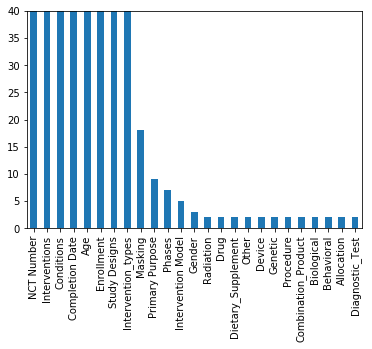

In [38]:
plt.ylim(0,40)
s = pd.Series(atr_cat).sort_values(ascending=False)
s.plot.bar()

In [46]:
#for val in df1['Conditions'].values:
#    v = val.split('|')
#    for s in v:
#        df1['Conditions'].apply(lambda x:similar(x,s)) > 0.5
#df1[df1['Conditions'].apply(lambda x:similar(x,s)) > 0.5].index

Int64Index([   0,  194,  260,  510,  589,  612,  862,  899, 1039, 1175, 1297,
            1339, 1667, 1807, 1814, 1925, 1933, 1951, 2230, 2408, 2435, 2469,
            2571, 2870, 2927, 2993, 3001, 3155, 3210, 3441, 3483, 3580, 3644,
            3715, 3736, 3812, 3872, 3924, 4270, 4812, 4861, 4997, 5018, 5099,
            5235, 5315, 5336, 5377, 5412, 5677, 5806, 5993, 6016, 6190, 6217,
            6480, 6595, 6618, 6644, 6856, 6999, 7274, 7292, 7297, 7305, 7410,
            7752, 7874, 7972, 8022, 8129, 8167, 8172, 8337, 8447, 8462, 8475,
            8558, 8578, 8622, 8637, 8712, 8971, 8996, 9229, 9416, 9493, 9638,
            9822, 9921, 9974],
           dtype='int64')

---
We can see from above graph features such as primary purpose, phases, Masking has higher number of categories.
Although we should reorder the above ordering after grouping similar categories, as explained in the case of Conditions since the grouping is done based on string matching, so we should group some categories with similar string content. (We can define a measure of similarity with sequence matching and presence of particular string)
Feature such as NCT Number is unqiue hence if patient know them we can narrow down our search to the exact clinical trial. But, In most cases patient won't be knowing it.
Large number of categories are shown by Age atribute, again we've to look for ways to club similar categories into one.
Once we get the proper grouping done, we can use the above approach to know what questions we should ask to narrow our search space.